<div class="alert alert-success" role="alert">
  <h5>Our Libraries</h5>
</div>


In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# For LSTM model
from keras.models import Sequential
from tensorflow.keras import layers

# Optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD



%matplotlib inline
plt.rcParams.update({'font.size': 20})



<div class="alert alert-success" role="alert">
  <h5>Our Constants</h5>
</div>


In [2]:
START = "2017-12-29"
END = "2022-12-15"
PAST_N_DAYS = 90
LEARNING_RATE = 0.001
EPOCHS = 20

<div class="alert alert-success" role="alert">
  <h5>Our Functions</h5>
</div>


In [3]:
def Target_to_date_x_y(df):
    df_as_np = df.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

In [4]:
def N_Target(df, first_date_str, last_date_str, n=3):
    
    first_date = pd.to_datetime(first_date_str)
    last_date  = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    
    while True:
        df_subset = df.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = df.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df

In [5]:
def check_stationarity(df):
    df = df.dropna()
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(df, autolag='AIC')

    if result[0] < result[4].get("1%"):
        print("Passes on the 1% Critial Value")
        
    elif result[0] < result[4].get("5%"):
        print("Passes on the 5% Critial Value")
    
    elif result[0] < result[4].get("10%"):
        print("Passes on the 10% Critial Value")
    
    else:
        print("Failed")


In [6]:
def do_stationarity(df):
    """ 
    This function takes a Non-stationarity DataFrame
    Returns a stationarity one by applying following equation
        df = df - df.shift(1)
    """
    df = df - df.shift(1)
    
    # Dropping the nulls, which is only the frist row in the dataframe
    df = df.dropna()
    
    return df

In [7]:
def inv_stationarity(df_original, df_stationarity):
    df_original = df_original.dropna()

    """ 
    Inverse stationarity function takes a the original & Stationarity DataFrame
    Returns a Stationarity originally form
    """
    dfr = (df_stationarity.cumsum()*df_stationarity.iloc[-1])

    from sklearn import preprocessing

    scaler = preprocessing.MinMaxScaler(feature_range=(df_original.min()[0], df_original.max()[0]))

    names = dfr.columns
    d = scaler.fit_transform(dfr)
    dfr = pd.DataFrame(d, columns=names)
    return dfr

In [8]:
def plotdf(df , mean = True):
    df = df.dropna()
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (25,8)
    plt.title("CIB stock market price for Five years")
    plt.ylabel("Price in USD")
    plt.xlabel("Time in Years")
    plt.plot(df.index, df['Close']);
    if mean:
        plt.axhline(df['Close'].mean());

In [9]:
def ADF_details(df):
    df = df.dropna()
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(df, autolag='AIC')
    print(f'ADF Statistic: {result[0]}\n')
    print(f'p-value: {result[1]}\n')
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')

In [10]:
def predict_sequences_multiple(model, firstValue, length):
    '''
    predict lenght consecutive values from a real one
    '''
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        # print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

<div class="alert alert-success" role="alert">
  <h5>Pulling CIB stock market prices form yahoo finance API</h5>
</div>


In [11]:
# Pulling the data form yahoo finance
import yfinance as yf

# Commercial International Bank in Egypt
df = yf.download('CIBEY', start = START, end = END)

[*********************100%***********************]  1 of 1 completed


<div class="alert alert-success" role="alert">
  <h5>Let's talk about the stock market</h5>
</div>


In [12]:
from plotly.offline import iplot
import plotly.graph_objs as go

trace = go.Ohlc(x=df.index,
                open=df.Open['1-2018'],
                high=df.High['1-2018'],
                low=df.Low['1-2018'],
                close=df.Close['1-2018'])

trace_all = go.Ohlc(x=df.index,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)
# iplot([trace_all])
iplot([trace])

In [13]:
df = df.filter(['Close'])

df = df.asfreq('b')

df = df.fillna(method="bfill")

In [14]:
df.tail()

Close
Date             
2022-12-08   1.25
2022-12-09   1.24
2022-12-12   1.29
2022-12-13   1.24
2022-12-14   1.28

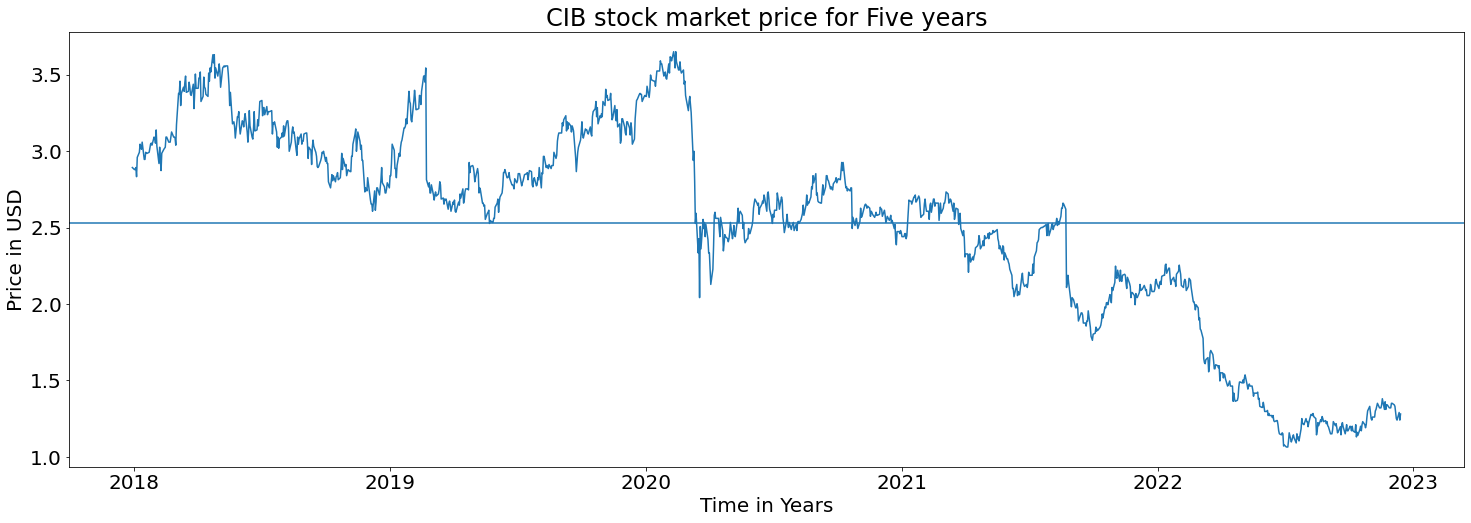

In [15]:
plotdf(df)

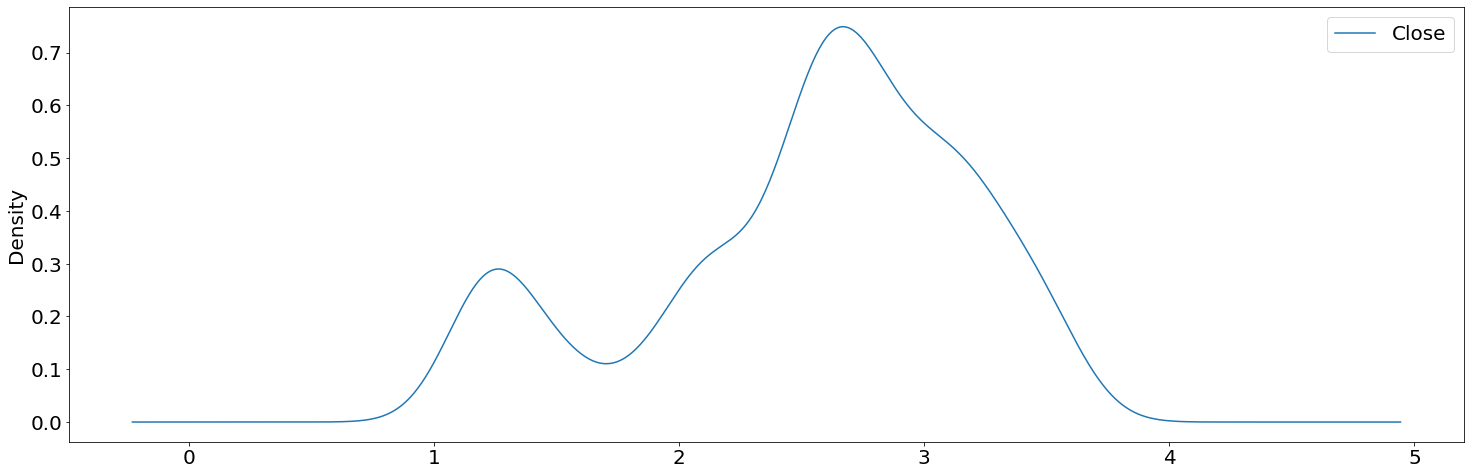

In [16]:
df.plot(kind='kde');

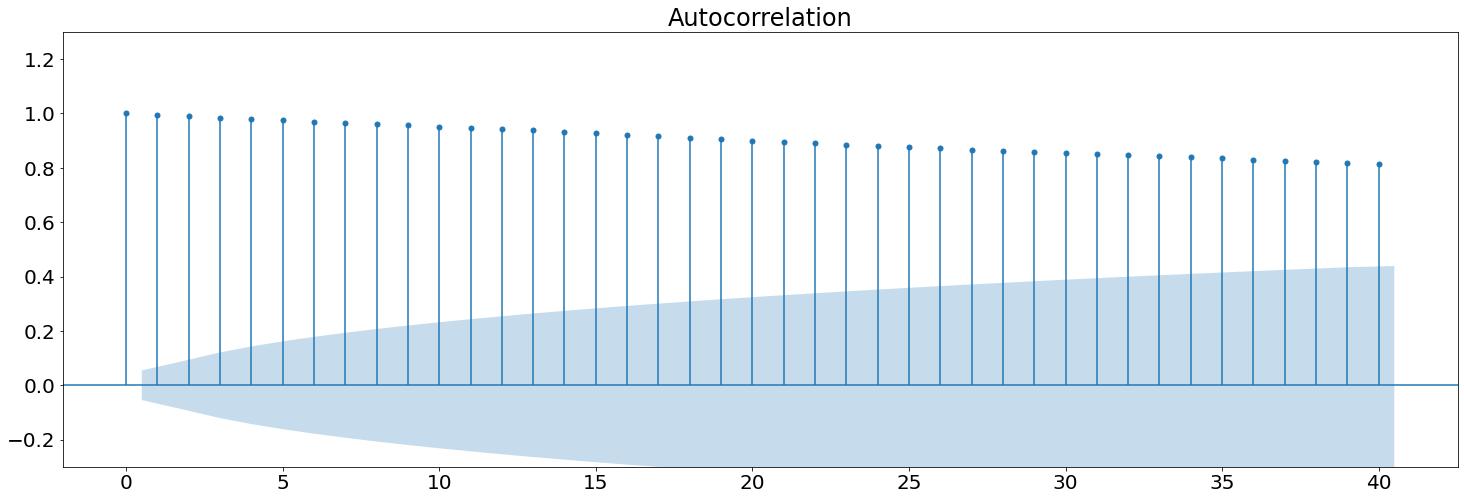

In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
plot_acf(df,lags=40)
plt.ylim(-0.3,1.3);

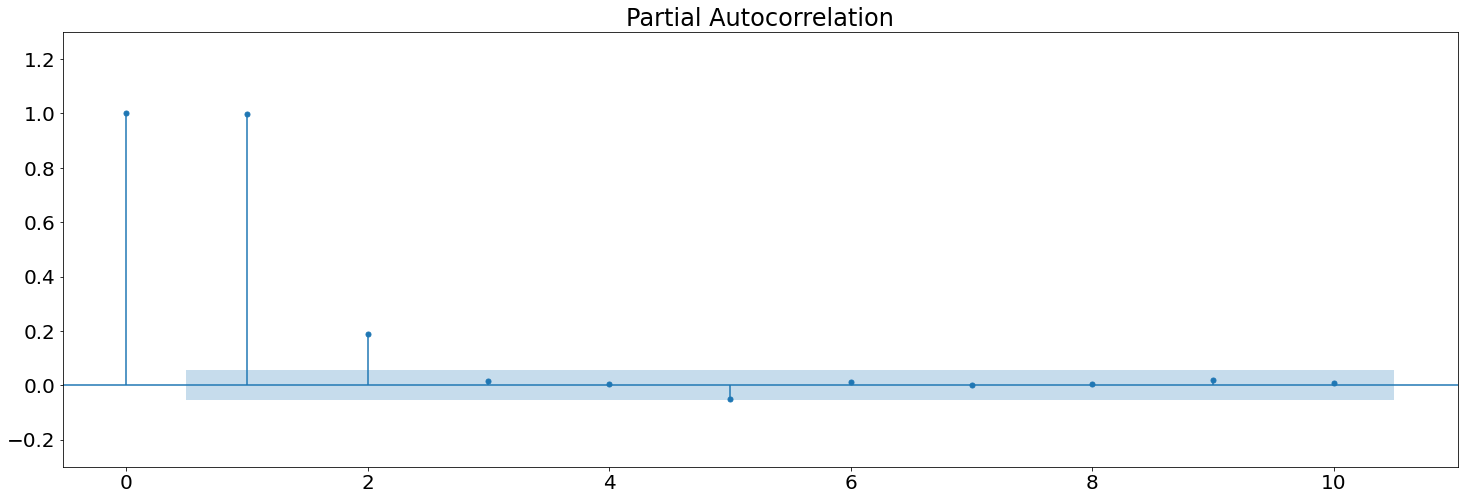

In [18]:
plot_pacf(df,lags=10, method='ols')
plt.ylim(-0.3,1.3);

# MinMaxScaler

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))

df = scaler.fit_transform(df)
df = pd.DataFrame(data = df, columns = ["Close"])

In [20]:
time = pd.date_range(start='2017-12-29',end='2022-12-14',freq='B')
df_time = pd.DataFrame(data = time, columns = ["index"])
df.index = time

In [21]:
Target_df = N_Target(df, 
                       '2018-06-01',
                       '2022-12-14',
                       n = PAST_N_DAYS)
Target_df

Target Date  Target-90  Target-89  Target-88  Target-87  Target-86  \
0     2018-06-01   0.763496   0.784062   0.781491   0.768638   0.802057   
1     2018-06-04   0.784062   0.781491   0.768638   0.802057   0.760925   
2     2018-06-05   0.781491   0.768638   0.802057   0.760925   0.717224   
3     2018-06-06   0.768638   0.802057   0.760925   0.717224   0.758355   
4     2018-06-07   0.802057   0.760925   0.717224   0.758355   0.724936   
...          ...        ...        ...        ...        ...        ...   
1179  2022-12-08   0.051414   0.061696   0.082262   0.082262   0.079692   
1180  2022-12-09   0.061696   0.082262   0.082262   0.079692   0.084833   
1181  2022-12-12   0.082262   0.082262   0.079692   0.084833   0.077121   
1182  2022-12-13   0.082262   0.079692   0.084833   0.077121   0.071979   
1183  2022-12-14   0.079692   0.084833   0.077121   0.071979   0.030848   

      Target-85  Target-84  Target-83  Target-82  ...  Target-9  Target-8  \
0      0.760925   0.717224   0.758355   0.724936  ...  0.817481  0.820051   
1      0.717224   0.758355   0.724936   0.699229  ...  0.820051  0.822622   
2      0.758355   0.724936   0.699229   0.742930  ...  0.822622  0.809769   
3      0.724936   0.699229   0.742930   0.753213  ...  0.809769  0.781491   
4      0.699229   0.742930   0.753213   0.755784  ...  0.781491  0.835476   
...         ...        ...        ...        ...  ...       ...       ...   
1179   0.084833   0.077121   0.071979   0.030848  ...  0.106776  0.099044   
1180   0.077121   0.071979   0.030848   0.041131  ...  0.099044  0.099044   
1181   0.071979   0.030848   0.041131   0.061696  ...  0.099044  0.099044   
1182   0.030848   0.041131   0.061696   0.053984  ...  0.099044  0.110643   
1183   0.041131   0.061696   0.053984   0.069409  ...  0.110643  0.110643   

      Target-7  Target-6  Target-5  Target-4  Target-3  Target-2  Target-1  \
0     0.822622  0.809769  0.781491  0.835476  0.835476  0.848329  0.812340   
1     0.809769  0.781491  0.835476  0.835476  0.848329  0.812340  0.791774   
2     0.781491  0.835476  0.835476  0.848329  0.812340  0.791774  0.825193   
3     0.835476  0.835476  0.848329  0.812340  0.791774  0.825193  0.822622   
4     0.835476  0.848329  0.812340  0.791774  0.825193  0.822622  0.809769   
...        ...       ...       ...       ...       ...       ...       ...   
1179  0.099044  0.099044  0.110643  0.110643  0.106776  0.102910  0.087445   
1180  0.099044  0.110643  0.110643  0.106776  0.102910  0.087445  0.071979   
1181  0.110643  0.110643  0.106776  0.102910  0.087445  0.071979  0.068113   
1182  0.110643  0.106776  0.102910  0.087445  0.071979  0.068113  0.087445   
1183  0.106776  0.102910  0.087445  0.071979  0.068113  0.087445  0.068113   

        Target  
0     0.791774  
1     0.825193  
2     0.822622  
3     0.809769  
4     0.830334  
...        ...  
1179  0.071979  
1180  0.068113  
1181  0.087445  
1182  0.068113  
1183  0.083578  

[1184 rows x 92 columns]

# REShaping

In [22]:
dates, x, y = Target_to_date_x_y(Target_df)
y = y.reshape(-1, 1)
dates.shape, x.shape, y.shape

((1184,), (1184, 90, 1), (1184, 1))

In [23]:
_80 = int(len(dates) * .8)
_90 = int(len(dates) * .9)

# Dates of the Train data & x_train & y_train => 80%
#(jan - 2018) upto (jan - 2022)
dates_train, x_train, y_train = dates[:_80], x[:_80], y[:_80]

#=============================================================

# Dates of the Validation & x_val & y_val => 10%
#(jan - 2022) upto (june - 2022)
dates_val, x_val, y_val = dates[_80:_90], x[_80:_90], y[_80:_90]


#=============================================================


# Dates of the Testing & x_Test & y_test => 10%
#(june - 2022) upto (dec - 2022)
dates_test, x_test, y_test = dates[_90:], x[_90:], y[_90:]


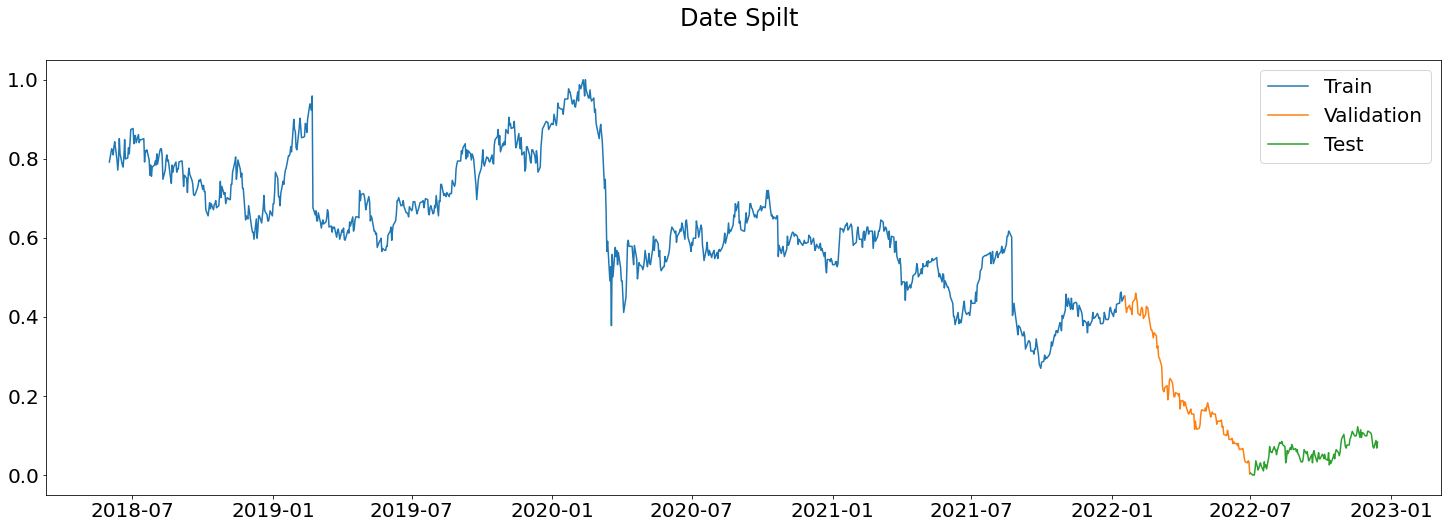

In [24]:
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Date Spilt \n")
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test']);

In [25]:
df_train=pd.DataFrame(y_train, columns=['Close'])
df_train.index = dates_train

<div class="alert alert-success" role="alert">
  <h3 class="alert-heading">Let's Talk About STATIONARITY!</h3>
  <hr>
  <p class="mb-0"><p>The word "Stationarity" means</p>
    <br> &ensp; &ensp; &#9673  &ensp;  Our $\mu$ is constant.
    <br> &ensp; &ensp; &#9673  &ensp;  Our $\sigma$ is constant
    <br> &ensp; &ensp; &#9673  &ensp;  We have NO Seasonality
    </p>
</div>

In [26]:
check_stationarity(df_train)

Failed


In [27]:
ADF_details(df_train)

ADF Statistic: -2.160298590808073

p-value: 0.22096888332201436

Critial Values:
   1%, -3.4372887850912175
   5%, -2.8646033071530703
   10%, -2.568401081996585


<div class="alert alert-warning" role="alert">
    ADF Statistic < None of the critical values
    <br>                    
     Thus, We don't have Stationarity
</div>

In [28]:
df_train_stationarity = do_stationarity(df_train)

In [29]:
df_train_stationarity.describe()

Close
count  946.000000
mean    -0.000359
std      0.026345
min     -0.282776
25%     -0.012854
50%      0.000000
75%      0.012854
max      0.179949

In [30]:
check_stationarity(df_train_stationarity)

Passes on the 1% Critial Value


In [31]:
df_train_stationarity

Close
2018-06-04  0.033419
2018-06-05 -0.002571
2018-06-06 -0.012853
2018-06-07  0.020565
2018-06-08  0.012854
...              ...
2022-01-11  0.000000
2022-01-12  0.025707
2022-01-13  0.002571
2022-01-14 -0.023136
2022-01-17  0.012854

[946 rows x 1 columns]

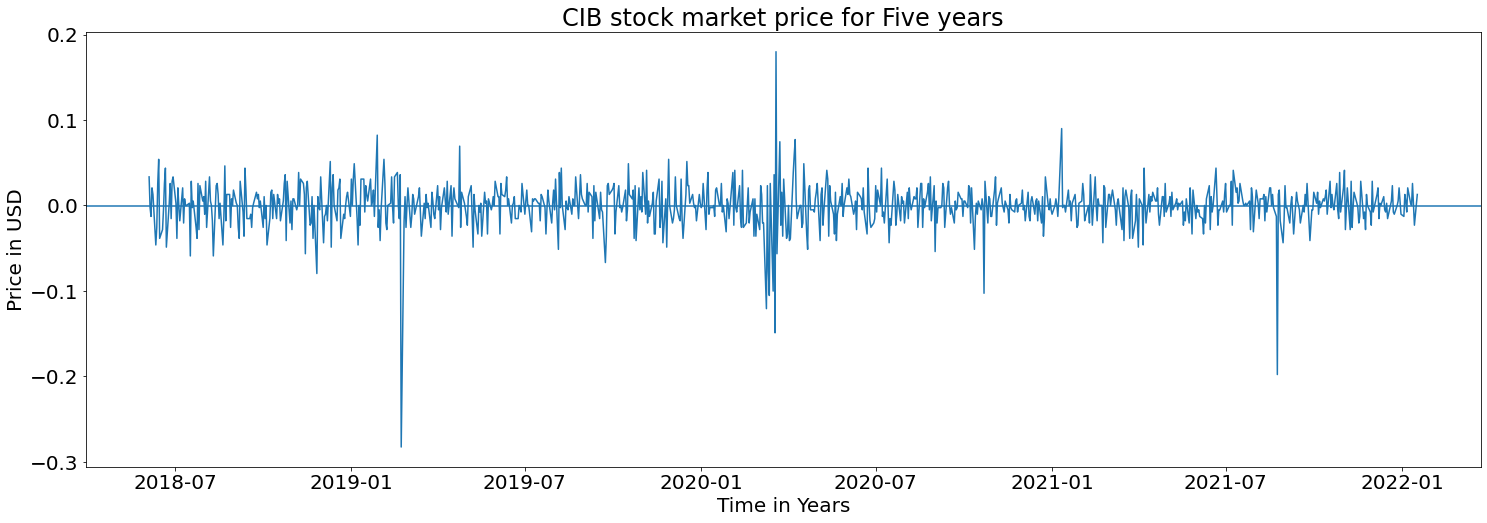

In [32]:
plotdf(df_train_stationarity)

In [33]:
Target_df_train = N_Target(df_train_stationarity, 
                       '2018-01-18',
                       '2018-07-11',
                       n = PAST_N_DAYS)
Target_df_train

# dates_train, x_train, y_train = Target_to_date_x_y(Target_df_train)

Error: Window of size 90 is too large for date 2018-01-18 00:00:00


<div class="alert alert-success" role="alert">
  <h1>Welcome to the LSTM Model</h1>  <hr>
    By Mohamed Essawey
</div>

![your_title](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS9O-bov7-EAqQznpuOg5yARFrItIelEEL5uqjlmBjfPSbAGEux39OWPocIgqxWQCm42FQ&usqp=CAU)


In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras import layers 

model = Sequential([layers.Input((PAST_N_DAYS, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='tanh'),
                    layers.Dense(32, activation='tanh'),
                    layers.Dense(1)])
'''
loss 
     : MAE - Mean Absolute Error - The L1 loss function
     : MSE - Mean Squared Error  - The L2 loss function
     : Huber loss - It calculates the quadratic loss by default (MSE)
     and if the loss exceeds the threshold, MAE is then calculated.
'''
model.compile(loss='mae', #L1
              optimizer=Adam(learning_rate = LEARNING_RATE),
              metrics=['mean_squared_error'])

# batch_size = 1 => batch GD
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1, epochs = 10 ,verbose = 1);

Epoch 1/10
947/947 [==============================] - 12s 11ms/step - loss: 0.0413 - mean_squared_error: 0.0041 - val_loss: 0.0175 - val_mean_squared_error: 4.5569e-04
Epoch 2/10
947/947 [==============================] - 10s 10ms/step - loss: 0.0289 - mean_squared_error: 0.0015 - val_loss: 0.0241 - val_mean_squared_error: 7.7604e-04
Epoch 3/10
947/947 [==============================] - 10s 10ms/step - loss: 0.0293 - mean_squared_error: 0.0015 - val_loss: 0.0171 - val_mean_squared_error: 4.5846e-04
Epoch 4/10
947/947 [==============================] - 10s 10ms/step - loss: 0.0266 - mean_squared_error: 0.0013 - val_loss: 0.0154 - val_mean_squared_error: 3.6702e-04
Epoch 5/10
947/947 [==============================] - 12s 12ms/step - loss: 0.0267 - mean_squared_error: 0.0013 - val_loss: 0.0143 - val_mean_squared_error: 3.5620e-04
Epoch 6/10
947/947 [==============================] - 10s 11ms/step - loss: 0.0261 - mean_squared_error: 0.0013 - val_loss: 0.0172 - val_mean_squared_error: 4.0

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________


In [36]:
# df_predict=pd.DataFrame(model.predict(x_train), columns=['predict'])

# df_predict

In [37]:
# for i in range(125):
#     x_train0 = np.append(x_train0, x_train[i][0])
#     x_train1 = np.append(x_train1, x_train[i][1])
#     x_train2 = np.append(x_train1, x_train[i][2])

In [38]:
# Traget_3 = pd.DataFrame(data = x_train0, 
#                   columns = ["Traget-3"])
# Traget_2 = pd.DataFrame(data = x_train1, 
#                   columns = ["Traget-2"])
# Traget_1 = pd.DataFrame(data = x_train2, 
#                   columns = ["Traget-1"])

In [39]:
# df_predict=pd.DataFrame(model.predict(x_train), columns=['predict'])

# train_predictions = inv_stationarity(df,df_predict)
# train_predictions.to_numpy()


30/30 [==============================] - 1s 9ms/step


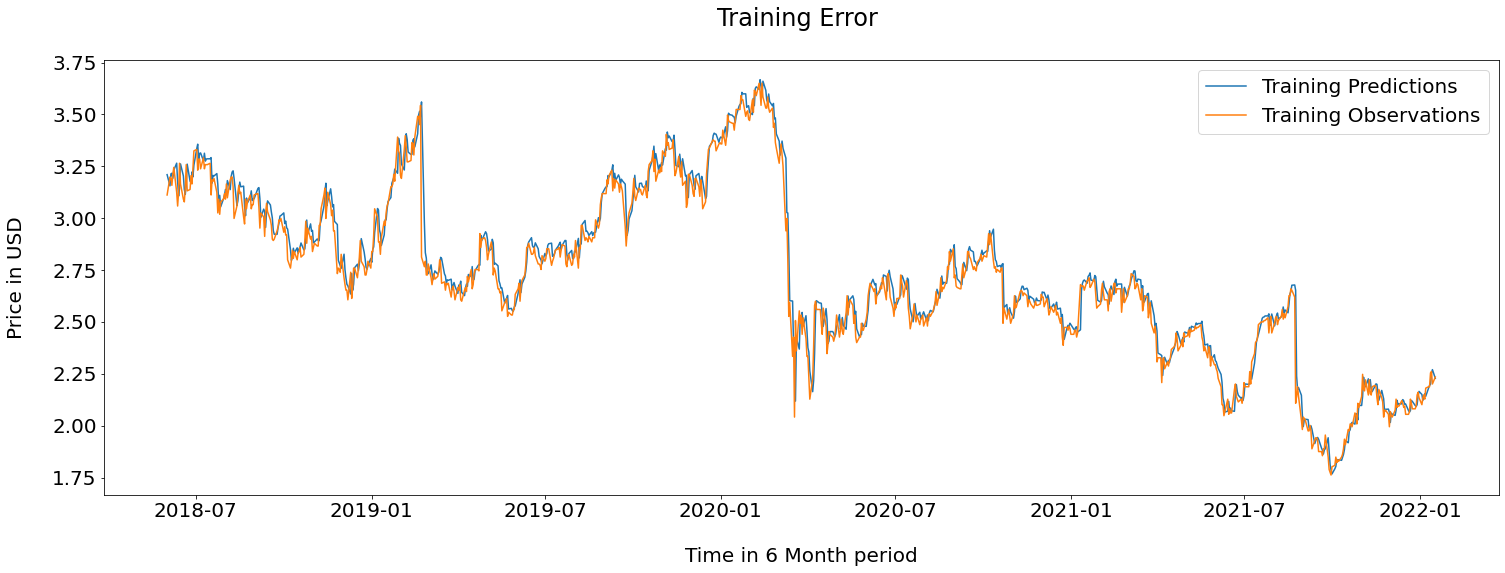

In [40]:
train_predictions = model.predict(x_train)

train_predictions=scaler.inverse_transform(train_predictions)
y_train=scaler.inverse_transform(y_train)

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.title("Training Error \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in 6 Month period")
plt.rcParams["figure.figsize"] = (25,8)
plt.legend(['Training Predictions', 'Training Observations']);

4/4 [==============================] - 0s 13ms/step


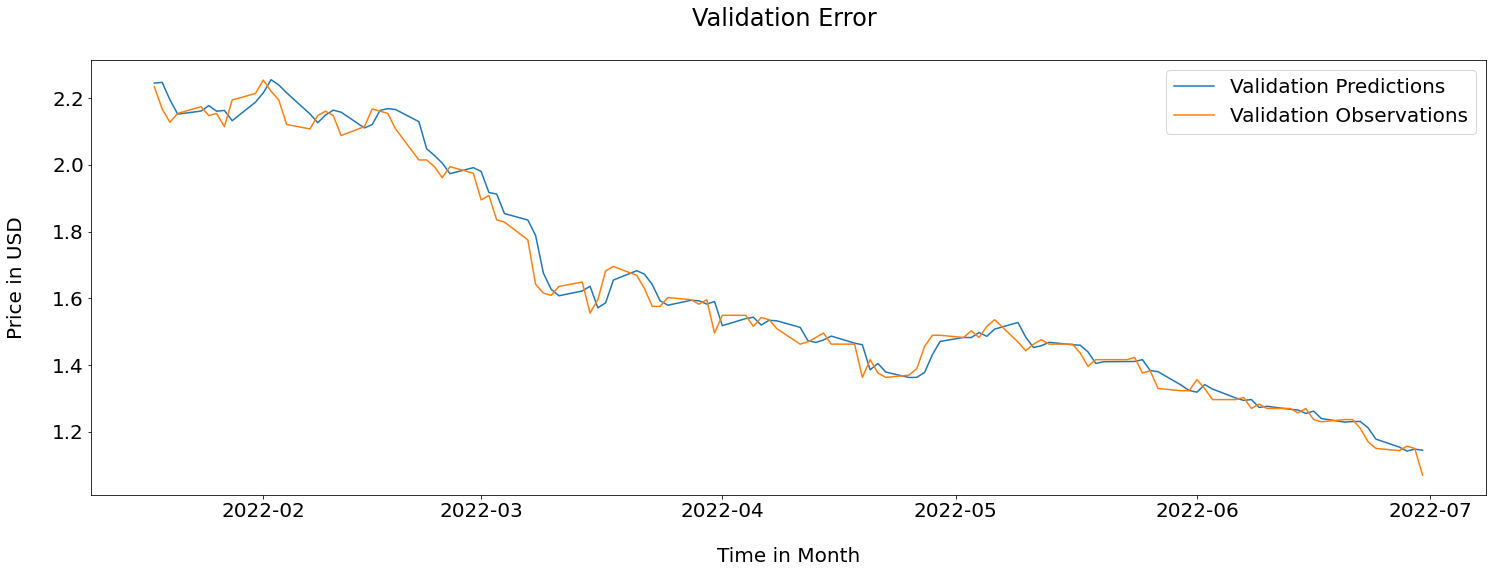

In [41]:
val_predictions = model.predict(x_val)

val_predictions=scaler.inverse_transform(val_predictions)
y_val=scaler.inverse_transform(y_val)

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Validation Error \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in Month")
plt.legend(['Validation Predictions', 'Validation Observations']);

4/4 [==============================] - 0s 9ms/step


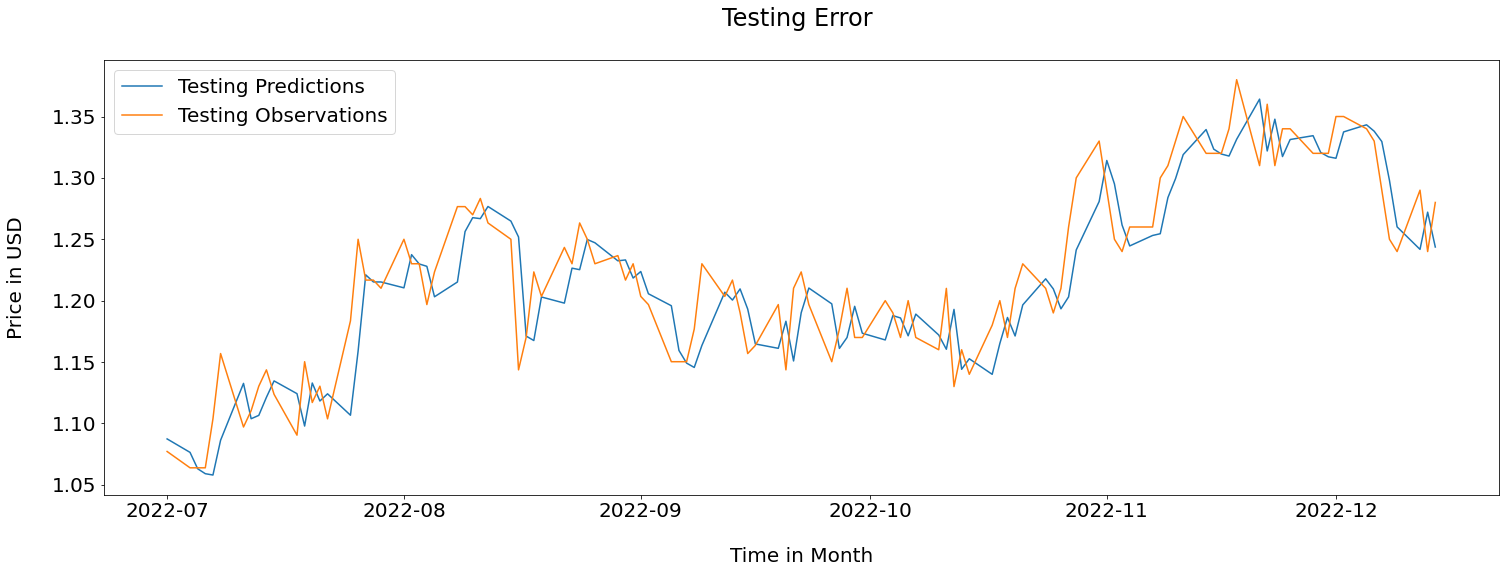

In [42]:
test_predictions = model.predict(x_test)

test_predictions=scaler.inverse_transform(test_predictions)
y_test=scaler.inverse_transform(y_test)


plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Testing Error \n")
plt.ylabel("Price in USD\n")
# plt.ylim(0.5,1.5)
plt.xlabel("\nTime in Month")

plt.legend(['Testing Predictions', 'Testing Observations']);

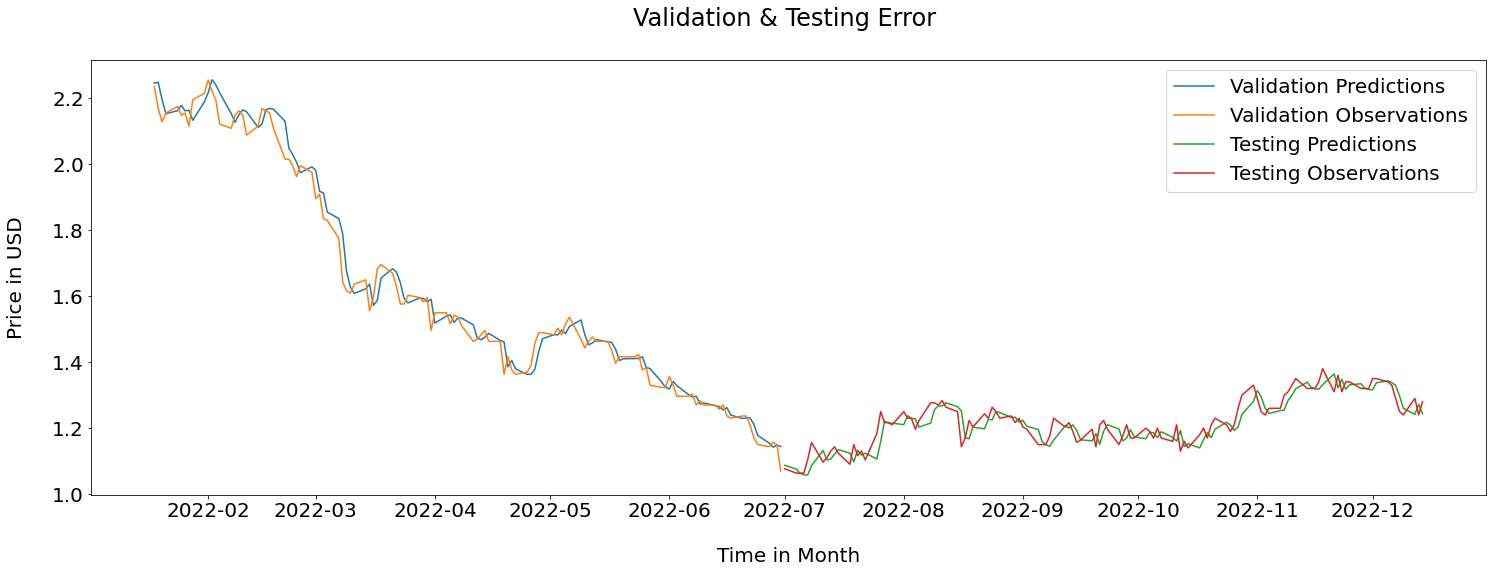

In [43]:
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Validation & Testing Error \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in Month")
plt.legend(['Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations']);

In [66]:
dates_test[-1]

Timestamp('2022-12-14 00:00:00')

In [85]:
from pandas import Timestamp
dates_recursive = pd.date_range(start=dates_test[-1],end=Timestamp('2023-01-01 00:00:00'),freq='B');


In [86]:
len(dates_recursive)

13

In [87]:
# demonstrate prediction for next 10 days
from numpy import array

x_input=y[len(y)-PAST_N_DAYS-1:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

y_recursive=[]
i=0

while(i<len(dates_recursive)):
    
    if(len(temp_input)>3):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, PAST_N_DAYS, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}\n".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        y_recursive.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, PAST_N_DAYS,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        y_recursive.extend(yhat.tolist())
        i=i+1
    

y_recursive = scaler.inverse_transform(y_recursive);

0 day input [0.08483294 0.0771208  0.07197935 0.03084825 0.04113111 0.0616965
 0.05398432 0.06940863 0.06426717 0.0771208  0.07197935 0.06426717
 0.0668379  0.05912577 0.06426717 0.05398432 0.05141401 0.03341897
 0.03341897 0.03341897 0.04370183 0.06426717 0.05398432 0.05912577
 0.04884328 0.03598965 0.03856038 0.05141401 0.03084825 0.05655504
 0.0616965  0.05141401 0.03341897 0.04370183 0.05655504 0.04104874
 0.04104874 0.05264775 0.04878143 0.04104874 0.05264775 0.04104874
 0.03718242 0.05651407 0.02558346 0.03718242 0.02944978 0.04491506
 0.05264775 0.04104874 0.05651407 0.06424671 0.05651407 0.04878143
 0.05651407 0.07584567 0.09131096 0.10290996 0.08744463 0.07197935
 0.06811303 0.07584567 0.07584567 0.09131096 0.09517728 0.10290996
 0.1106426  0.09904364 0.09904364 0.09904364 0.10677628 0.12224156
 0.09517728 0.11450893 0.09517728 0.10677628 0.10677628 0.09904364
 0.09904364 0.09904364 0.1106426  0.1106426  0.10677628 0.10290996
 0.08744463 0.07197935 0.06811303 0.08744463 0.0681

12 day output [[0.06155296]]



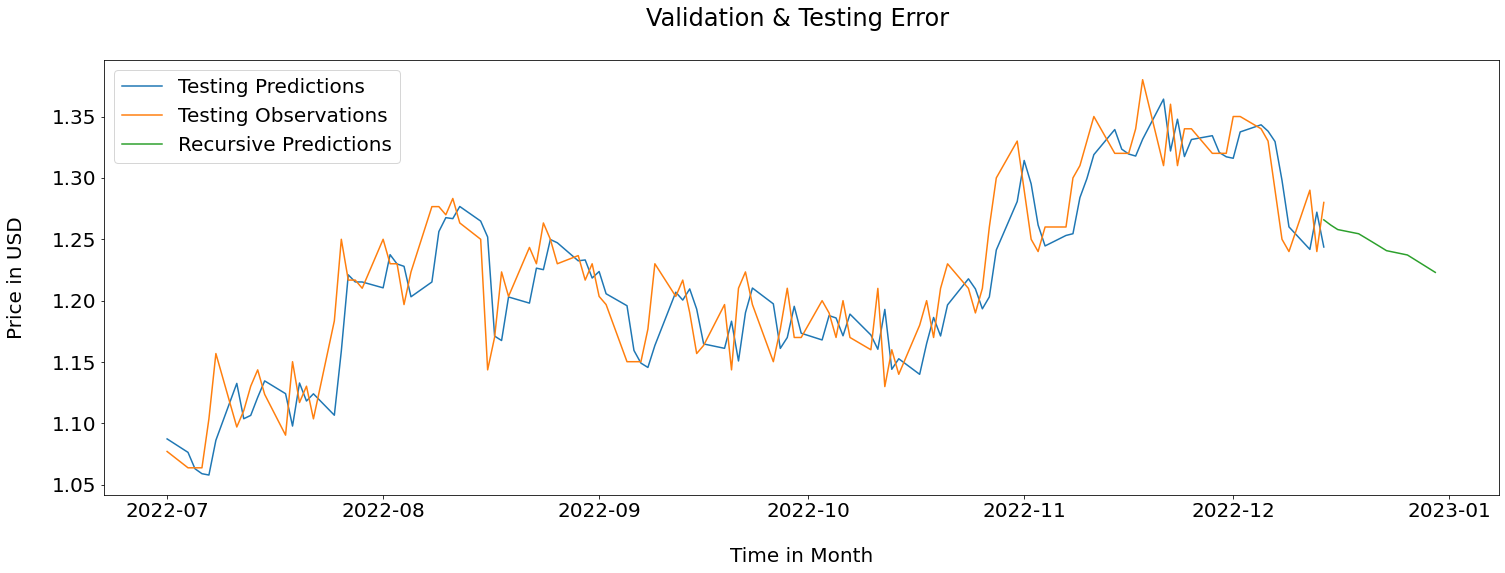

In [88]:
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
# plt.plot(dates_val, val_predictions)
# plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)

plt.plot(dates_recursive,y_recursive)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Validation & Testing Error \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in Month")
plt.legend(['Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions']);

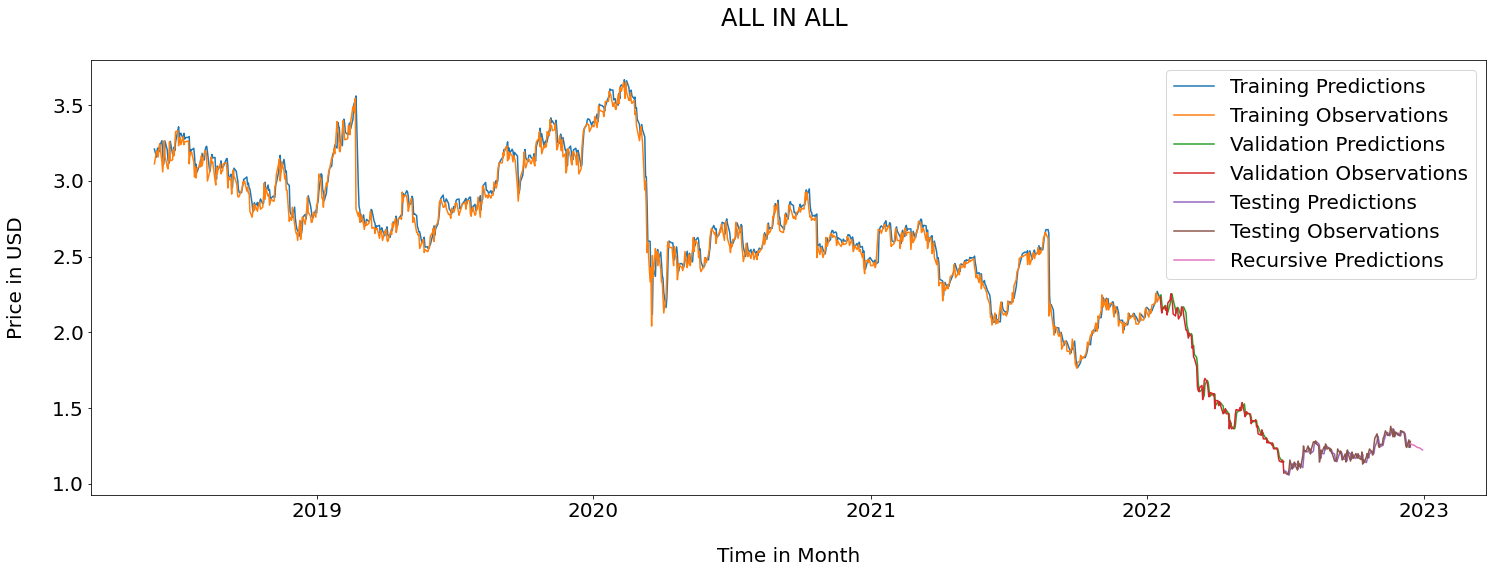

In [90]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)

plt.plot(dates_recursive,y_recursive)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("ALL IN ALL \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in Month")
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions']);